# Shapley for data valuation

This notebook introduces Shapley methods for the computation of data value using pyDVL.

In order to illustrate the practical advantages, we will predict the popularity of songs in the dataset [Top Hits Spotify from 2000-2019](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019), and highlight how data valuation can help investigate and boost the performance of the models. In doing so, we will describe the basic usage patterns of pyDVL.

Recall that data value is a function of three things:

1. The dataset.
2. The model.
3. The performance metric or scoring function.

Below we will describe how to instantiate each one of these objects and how to use them for data valuation. Please also see the [documentation on data valuation](../../value/).

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [ ]:
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics._scorer import neg_mean_absolute_error_scorer

from support.shapley import load_spotify_dataset

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
random_state = 24
random.seed(random_state)

We will use the following classes and functions from pyDVL. The main entry point is the class
[ShapleyValuation][pydvl.valuation.methods.shapley.ShapleyValuation], which provides the implementation of the Shapley method. In order to use it we need to instantiate two [Datasets][pydvl.valuation.dataset.Dataset], a [PermutationSampler][pydvl.valuation.samplers.PermutationSampler] (with a [RelativeTruncation][pydvl.valuation.samplers.truncation.RelativeTruncation] policy to stop computation early), a [SupervisedScorer][pydvl.valuation.scorers.SupervisedScorer] to evaluate the model on the held-out test set, and a [ModelUtility][pydvl.valuation.utility.ModelUtility] to hold the model and the scoring function.

In [ ]:
from pydvl.reporting.plots import plot_shapley
from pydvl.valuation.dataset import Dataset, GroupedDataset
from pydvl.valuation.methods.shapley import ShapleyValuation
from pydvl.valuation.samplers import PermutationSampler
from pydvl.valuation.samplers.truncation import RelativeTruncation
from pydvl.valuation.scorers import SupervisedScorer
from pydvl.valuation.stopping import AbsoluteStandardError, MaxUpdates
from pydvl.valuation.utility import ModelUtility

## Loading and grouping the dataset

pyDVL provides a support function for this notebook, `load_spotify_dataset()`, which downloads data on songs published after 2014, and splits 30% of data for testing, and 30% of the remaining data for validation. The return value is a triple of training, validation and test data as lists of the form `[X_input, Y_label]`.

In [ ]:
train_data, val_data, test_data = load_spotify_dataset(
    val_size=0.3, test_size=0.3, target_column="popularity", random_state=random_state
)

In [ ]:
# In CI we only use a subset of the training set
if is_CI:
    ci_test_artists = ["Billie Eilish", "DJ Snake", "Eminem", "Adele", "Maroon 5"]
    train_data[0] = train_data[0][train_data[0]["artist"].isin(ci_test_artists)]
    train_data[1] = train_data[1][train_data[0].index]

In [ ]:
train_data[0].head()

The dataset has many high-level features, some quite intuitive (`duration_ms` or `tempo`), while others are a bit more cryptic (`valence`?).

For detailed information on each feature, please consult [the dataset's website](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019).

In our analysis, we will use all the columns, except for `artist` and `song`, to predict the `popularity` of each song.

In [7]:
artists = train_data[0]["artist"]
train_data[0] = train_data[0].drop(["artist"], axis=1)
test_data[0] = test_data[0].drop(["artist"], axis=1)
val_data[0] = val_data[0].drop(["artist"], axis=1)

Input and label data are then used to instantiate [Dataset](../../api/pydvl/valuation/dataset/#pydvl.valuation.dataset.Dataset) objects:

In [8]:
train_dataset = Dataset(*train_data)
val_dataset = Dataset(*val_data)

The calculation of exact Shapley values is computationally very expensive (exponentially so!) because it requires training the model on every possible subset of the training set. For this reason, PyDVL implements techniques to speed up the calculation, such as Monte Carlo approximations, [surrogate models](../../api/pydvl/valuation/utility/learning/#pydvl.valuation.utility.learning.DataUtilityLearning) or [caching](../../api/pydvl/utils/caching/) of intermediate results and grouping of data to calculate Shapley values of groups of data points instead of single data points.

In our case, we will group songs by artist and calculate the Shapley values for the artists.
We use the pandas Series `artists` to group the dataset as follows:

In [9]:
grouped_train_dataset = GroupedDataset.from_dataset(train_dataset, data_groups=artists)

## Creating the utility and computing values

Now we can calculate the contribution of each group to the model performance.

As a model, we use scikit-learn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), but pyDVL can work with any model from sklearn, xgboost or lightgbm. More precisely, any model that implements the protocol [SupervisedModel](../../api/pydvl/utils/types/#pydvl.utils.types.SupervisedModel), which is just the standard sklearn interface of `fit()`,`predict()` and `score()` can be used to construct the utility.

The third and final component is the scoring function. It can be anything like accuracy or $R^2$, and is set, in the simplest way, by passing a string from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html) to the `SupervisedScorer` class. Please refer to that documentation on information on how to define your own scoring function.

We group validation dataset, model and scoring function into an instance of [ModelUtility](../../api/pydvl/valuation/utility/#pydvl.valuation.utility.ModelUtility).

In [ ]:
utility = ModelUtility(
    model=GradientBoostingRegressor(n_estimators=3, random_state=random_state),
    scorer=SupervisedScorer(
        "neg_mean_absolute_error", test_data=val_dataset, default=0.0
    ),
)
valuation = ShapleyValuation(
    utility=utility,
    sampler=PermutationSampler(
        truncation=RelativeTruncation(rtol=0.01), seed=random_state
    ),
    # Stop if the standard error is below 1% of the range of the values (which is ~2),
    # or if the number of updates exceeds 1000
    is_done=AbsoluteStandardError(threshold=0.2, fraction=0.9) | MaxUpdates(1000),
)
valuation.fit(grouped_train_dataset)
values = valuation.values()
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

We must pass a stopping criterion to the method's `is_done` argument, in order to avoid spending time doing extra computations after convergence.

In this case we choose to stop when the ratio of standard error to value is below 0.2 for at least 90% of the training points, or if the number of updates of any index exceeds 1000. Given our choice of stopping criterion and sampler (`PermutationSampler`) with truncation, the method we use is the Truncated Monte Carlo approximation, which is the fastest of the Monte Carlo methods, owing both to using the permutation definition of Shapley values and the ability to truncate the iteration over a given permutation. We configure this to happen when the contribution of the remaining elements is below 1% of the total utility with the parameter `truncation=` and the policy [RelativeTruncation](../../api/pydvl/valuation/samplers/truncation/#pydvl.valuation.samplers.truncation.RelativeTruncation).

Let's take a look at the returned dataframe:

In [11]:
df.head()

,data_value,data_value_stderr
Silentó,-1.162980,0.409141
Astrid S,-0.999800,0.369783
BLACKPINK,-0.894791,0.267918
CNCO,-0.892243,0.321871
Zedd,-0.845923,0.318318


The first thing to notice is that we sorted the results in ascending order of Shapley value. The index holds the labels for each data group: in this case, artist names. The column `data_value` is just that: the Shapley Data value, and `data_value_stderr` is its estimated standard error because we are using a Monte Carlo approximation.

Let us plot the results. In the next cell we will take the 30 artists with the lowest score and plot their values with 95% Normal confidence intervals. Keep in mind that Monte Carlo Shapley is typically very noisy, and it can take many steps to arrive at a clean estimate.

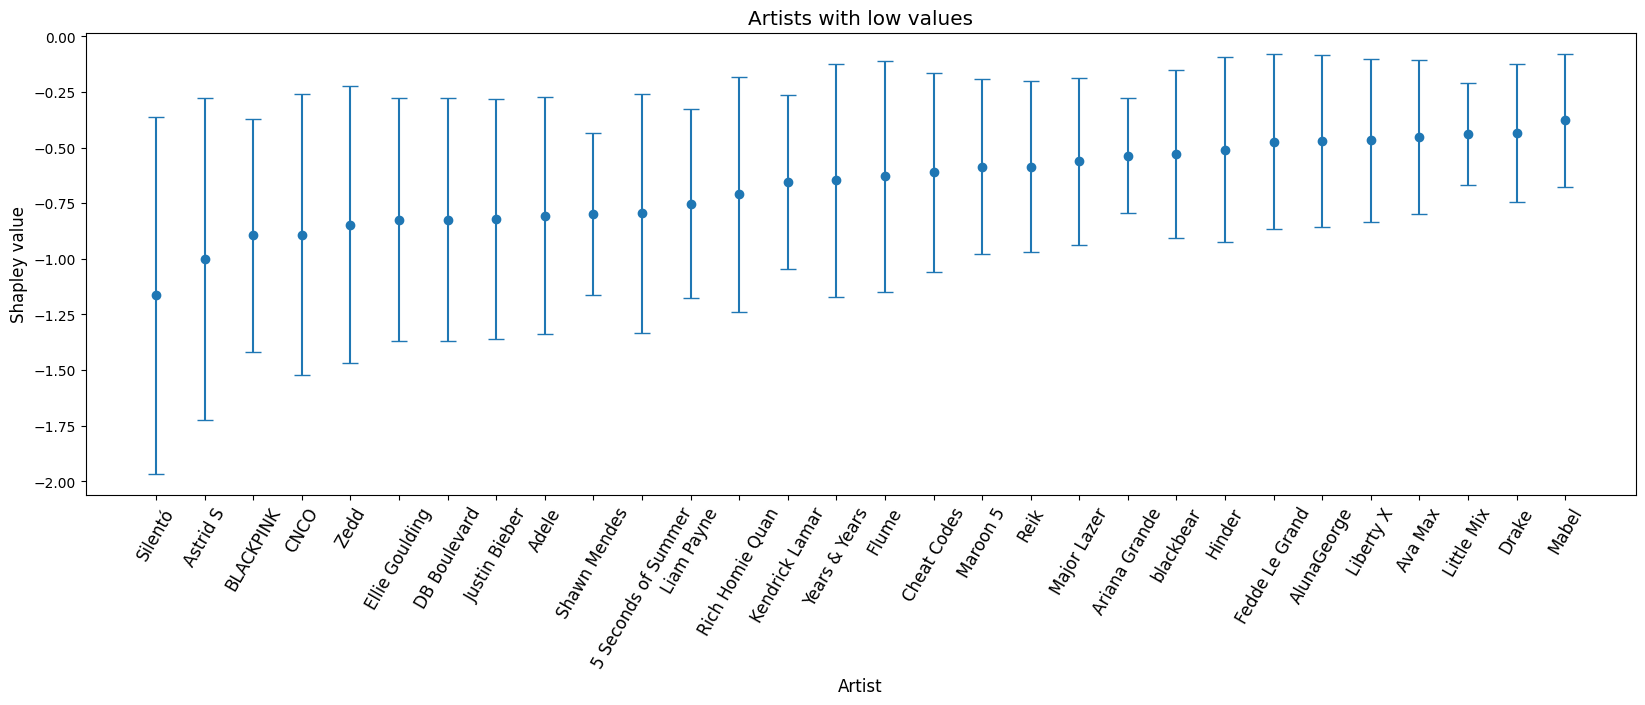

In [12]:
low_dvl = df.iloc[:30]
plot_shapley(
    low_dvl,
    level=0.05,
    title="Artists with low values",
    xlabel="Artist",
    ylabel="Shapley value",
)
plt.show()

We can immediately see that many artists (groups of samples) have very low, even negative value, which means that they tend to decrease the total score of the model when present in the training set! What happens if we remove them?

In the next cell we create a new training set excluding the artists with the lowest scores:

In [13]:
low_dvl_artists = df.iloc[: int(0.2 * len(df))].index.to_list()
artist_filter = ~artists.isin(low_dvl_artists)
X_train_good_dvl = train_data[0][artist_filter]
y_train_good_dvl = train_data[1][artist_filter]

Now we will use this **"cleaned"** dataset to retrain the same model and compare its mean absolute error to the one trained on the full dataset. Notice that the score now is calculated using the test set, while in the calculation of the Shapley values we were using the validation set.

In [ ]:
model_good_data = GradientBoostingRegressor(
    n_estimators=3, random_state=random_state
).fit(X_train_good_dvl, y_train_good_dvl)
error_good_data = neg_mean_absolute_error_scorer(
    model_good_data, test_data[0], test_data[1]
)

model_all_data = GradientBoostingRegressor(n_estimators=3).fit(
    train_data[0], train_data[1]
)
error_all_data = neg_mean_absolute_error_scorer(
    model_all_data, test_data[0], test_data[1]
)

print(f"Improvement: {100 * (error_all_data - error_good_data) / error_all_data:02f}%")

The score has improved by a noticeable amount! This is quite an important result, as it shows a consistent process to improve the performance of a model by excluding data points from its training set.

<div class="alert alert-warning">

One must however proceed with caution instead of simply throwing away data. For one, <code>neg_mean_absolute_error</code> is an estimate of generalization error on unseen data, so the improvement we see on the test set might not be as large upon deployment. It would be advisable to cross-validate this whole process to obtain more conservative estimates. It is also advisable to manually inspect the artists with low value and to try to understand the reason why the model behaves like it does. Finally, remember that <b>the value depends on the model chosen!</b> Artists that are detrimental to the Gradient Boosting Regressor might be informative for a different model (although it is likely that the worst ones share some characteristic making them "bad" for other regressors).

</div>

## Evaluation on anomalous data

One interesting test is to corrupt some data and to monitor how their value changes. To do this, we will take one of the artists with the highest value and set the popularity of all their songs to 0.

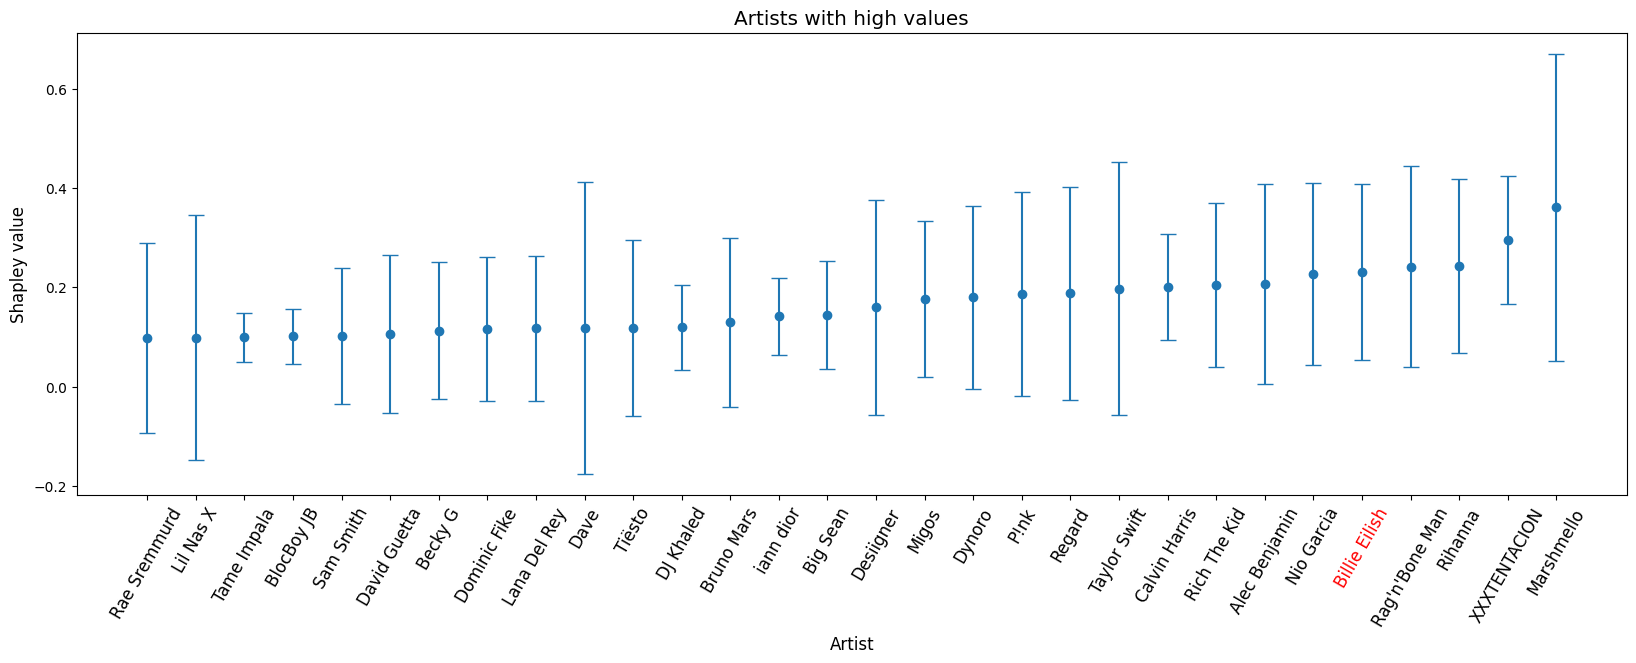

In [15]:
high_dvl = df.iloc[-30:]
ax = plot_shapley(
    high_dvl,
    title="Artists with high values",
    xlabel="Artist",
    ylabel="Shapley value",
)
ax.get_xticklabels()[high_dvl.index.get_loc("Billie Eilish")].set_color("red")
plt.show()

Let us take all the songs by Billie Eilish, set their score to 0 and re-calculate the Shapley values.

In [16]:
y_train_anomalous = train_data[1].copy(deep=True)
y_train_anomalous[artists == "Billie Eilish"] = 0
anomalous_train_dataset = Dataset(train_data[0], y_train_anomalous)
grouped_anomalous_dataset = GroupedDataset.from_dataset(
    anomalous_train_dataset, data_groups=artists
)

In [ ]:
anomalous_utility = ModelUtility(
    model=GradientBoostingRegressor(n_estimators=3, random_state=random_state),
    scorer=SupervisedScorer(
        "neg_mean_absolute_error", test_data=val_dataset, default=0.0
    ),
)
valuation = ShapleyValuation(
    utility=anomalous_utility,
    sampler=PermutationSampler(
        truncation=RelativeTruncation(rtol=0.01), seed=random_state
    ),
    # Stop if the standard error is below 1% of the range of the values (which is ~2),
    # or if the number of updates exceeds 1000
    is_done=AbsoluteStandardError(threshold=0.2, fraction=0.9) | MaxUpdates(1000),
)
valuation.fit(grouped_anomalous_dataset)
values = valuation.values()
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

Let us now consider the low-value artists (at least for predictive purposes, no claims are made about their artistic value!) and plot the results

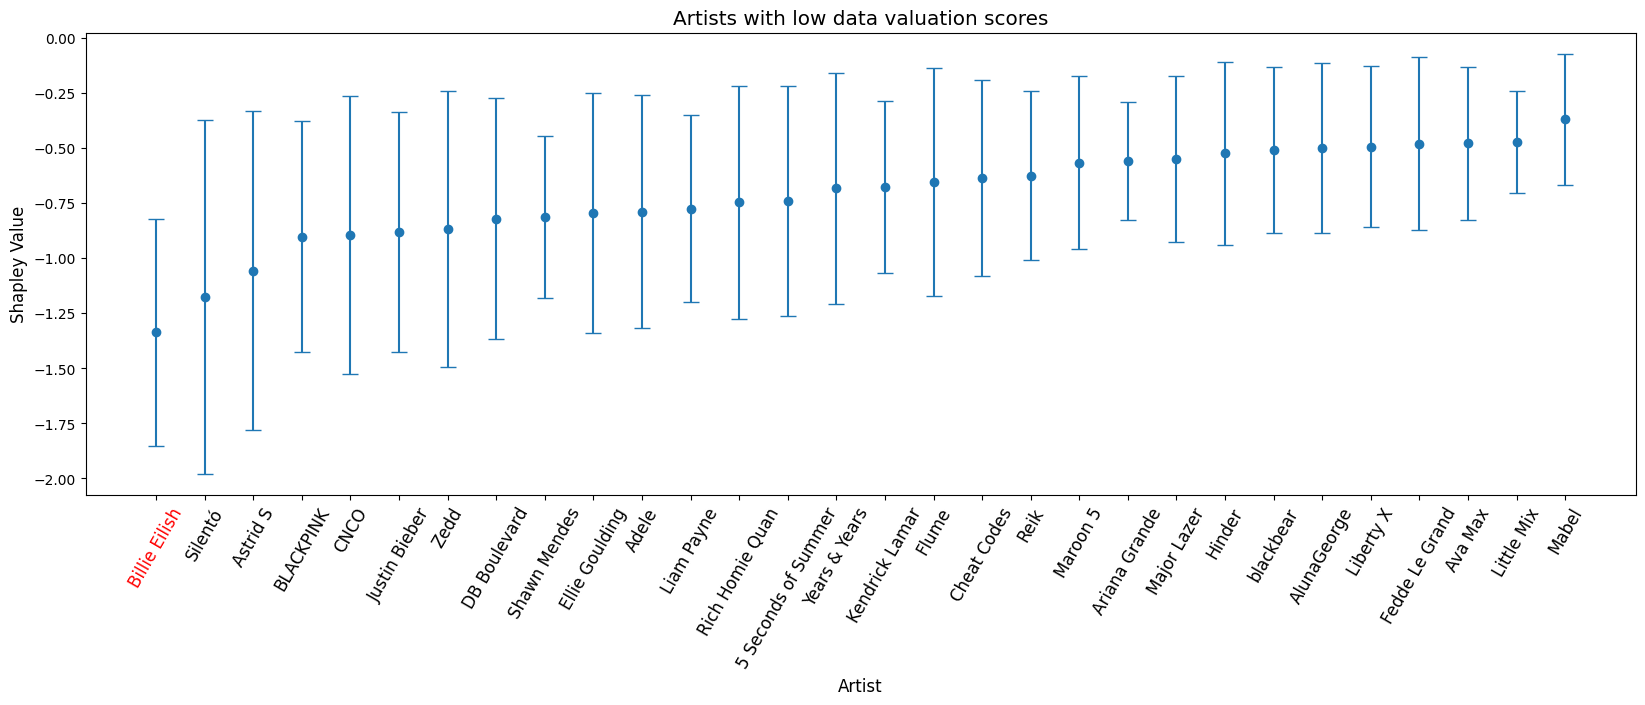

In [18]:
low_dvl = df.iloc[:30]
ax = plot_shapley(
    low_dvl,
    title="Artists with low data valuation scores",
    xlabel="Artist",
    ylabel="Shapley Value",
)
ax.get_xticklabels()[low_dvl.index.get_loc("Billie Eilish")].set_color("red")
plt.show()

And Billie Eilish (our anomalous data group) has moved from top contributor to having negative impact on the performance of the model, as expected!

What is going on? A popularity of 0 for Billie Eilish's songs is inconsistent with listening patterns for other artists. In artificially setting this, we degrade the predictive power of the model.

By dropping low-value groups or samples, one can often increase model performance, but by *inspecting* them, it is possible to identify bogus data sources or acquisition methods.
